### Generative Advesarial Network (GAN)

Implementing a DCGAN in this notebook we are going to follow some of the steps that comes from [this](https://arxiv.org/abs/1511.06434) paper.

**This paper implements a DCGAN as follows:**

* No pre-processing was applied to training images besides scaling to the range of the tanh activation function [-1, 1].
* All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128.
* All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.
* In the LeakyReLU, the slope of the leak was set to 0.2 in all models.
* We used Adam optimizer(Kingma & Ba, 2014) with tuned hyperparameters. We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead.
* Additionally, we found leaving the momentum term $\beta{1}$ at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.


**The paper also provides the following architecture guidelines for stable Deep Convolutional GANs:**

* Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
* Use batchnorm in both the generator and the discriminator.
* Remove fully connected hidden layers for deeper architectures.
* Use ReLU activation in generator for all layers except for the output, which uses Tanh.
* Use LeakyReLU activation in the discriminator for all layers.

**Some usefull internet resorces**
1. [TensorFlow Tutorial](https://www.tensorflow.org/tutorials/generative/dcgan)
2. [Medium blog post](https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9)
3. [GitHub](https://github.com/eriklindernoren/Keras-GAN)
4. [GitHub](https://github.com/platonovsimeon/dcgan-facegenerator)


#### Evaluating a GAN
The following diagram show a GAN.

<p align="center">
<img src="https://camo.githubusercontent.com/ef5522896db39c26403f49513cb54905d6f947ee/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6a656666686561746f6e2f7438315f3535385f646565705f6c6561726e696e672f6d61737465722f696d616765732f67616e5f6669675f312e706e67" alt=""/>
</p>
The discriminator `D` accepts an image as its input and produces number that is the probability of the input image being real. The generator `G` accepts a random seed vector and generates an image from that random vector seed. An unlimited number of new images can be created by providing additional seeds.


### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import os, PIL, time, tqdm
from tensorflow.keras.preprocessing import image, image_dataset_from_directory

In [67]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

### Data Preparation.

[Face dataset](https://www.kaggle.com/gasgallo/faces-data-new)


### Hyper parameters.

1. `GENERATE_RES` - Generation resolution factor
* This must be a square
* Trainning data will also be scalled on this
* Note GENERATE_RES 4 or higher will blow Google CoLab's memory and have not been tested extensivly.

* **GEN_RESOLUTION FACTORS**:
```py
# (1=32, 2=64, 3=96, 4=128, etc.)
```
In our case we are going to use the generating resolution of `3` (96 x 96).

2. Channels
We are going with 3 color channels

3. Data Path
This is where our data is located in our google drive. Make sure you have uploaded the data on your drive and you mounted the drive on Google Colab otherwise it won't work.

4. Other Hyper parameters

```py
DATA_PATH = '/content/drive/My Drive/images'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 60000
SEED_SIZE = 100
IMAGE_CHANNELS = 3
GENERATE_SQUARE = 32 * GENERATE_RES
GENERATE_RES = 3
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16
```

### Hyper parameters

In [2]:
DATA_PATH = '/content/drive/My Drive/faces'
EPOCHS = 50
BATCH_SIZE = 32
BUFFER_SIZE = 1500
SEED_SIZE = 100
IMAGE_CHANNELS = 3
GENERATE_RES = 3
GENERATE_SQUARE = 32 * GENERATE_RES
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

In [3]:
datagen = image.ImageDataGenerator(
    rescale=1.0 / 255,
    data_format = "channels_last",
    dtype = tf.float32,
)

In [4]:
train_dataset = datagen.flow_from_directory(
    DATA_PATH,
    target_size=(GENERATE_SQUARE, GENERATE_SQUARE),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation='nearest',
)

Found 1850 images belonging to 1 classes.


### Reading images Only from the dataset.

We are doing this because we want to create tensor slices, so that we will be able to create a dataset later on that we will be using to train our end to end GAN.

In [ ]:
def create_image_tensors(): 
  images = []
  start = time.time()
  for batch in train_dataset:
    start_batch = time.time()
    print(f"Images found {len(batch[0])}")
    for image in batch[0]:
      images.append(image)
    print(f"Done appending {len(batch[0])}, ETA: { time.time() - start}")
    print(f"Now we have {len(images)} image(s)")
    if (len(images) >= 10000):
      break
  print(f"ETA: { time.time() -start}")
  return images

### Saving the picke file

Since the previous operation can takes a lot of time we can save images in numpy binary format by calling `np.save()` function.

In [7]:
training_binary_path = os.path.join(DATA_PATH, f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')
if os.path.exist(training_binary_path):
  print("Loading the esisting pickle")
  training_data = np.load(training_binary_path)
else:
  images = create_image_tensors()
  np.save(training_binary_path, images, allow_pickle=True)
  training_data = np.load(training_binary_path)
print("Loaded")

### Creating dataset from tensor slices.

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
for batch in train_ds:
  break

### Plotting Real Images from the dataset.

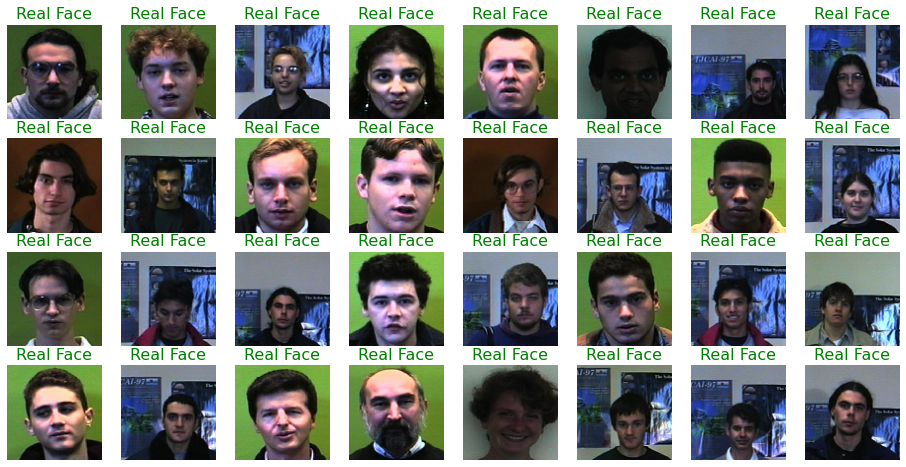

In [10]:
def plot_images(images_and_classes, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap="gray")
        plt.title("Real Face", color ='g', fontsize=16 )

plot_images(batch[:], cols=8)

### Images can also be loaded as follows code stolen from

* [jeffheaton](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb)

In [ ]:
from PIL import Image
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}-tut.npy')
print(f"Looking for file: {training_binary_path}")
if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH,'images')
  for filename in tqdm.tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

### Building Generator model and Descriminator (clean code)

```py
def build_discriminator(image_shape):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(keras.layers.LeakyReLU(alpha=0.2))

    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(keras.layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.LeakyReLU(alpha=0.2))

    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.LeakyReLU(alpha=0.2))

    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.LeakyReLU(alpha=0.2))

    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.LeakyReLU(alpha=0.2))

    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

def build_generator(seed_size, channels):
    model = keras.Sequential()

    model.add(keras.layers.Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(keras.layers.Reshape((4,4,256)))

    model.add(keras.layers.UpSampling2D())
    model.add(keras.layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.Activation("relu"))

    model.add(keras.layers.UpSampling2D())
    model.add(keras.layers.Conv2D(256,kernel_size=3,padding="same"))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(keras.layers.UpSampling2D())
    model.add(keras.layers.Conv2D(128,kernel_size=3,padding="same"))
    model.add(keras.layers.BatchNormalization(momentum=0.8))
    model.add(keras.layers.Activation("relu"))

    if GENERATE_RES>1:
      model.add(keras.layers.UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(keras.layers.Conv2D(128,kernel_size=3,padding="same"))
      model.add(keras.layers.BatchNormalization(momentum=0.8))
      model.add(keras.layers.Activation("relu"))

    # Final CNN layer
    model.add(keras.layers.Conv2D(channels,kernel_size=3,padding="same"))
    model.add(keras.layers.Activation("tanh"))

    return model
```

### The generator Model.
We are going to build the generator model using subclassing approach on blocks of layers

In [68]:
class GBlock(keras.layers.Layer):
  def __init__(self, in_features, kernel_size=3, activation="relu", momentum=0.8, padding="same", sampling_size=None ):
    super(GBlock, self).__init__()

    if sampling_size:
      self.up_sampler = keras.layers.UpSampling2D(size=sampling_size)
    else:
      self.up_sampler = keras.layers.UpSampling2D()
    self.conv = keras.layers.Conv2D(in_features, kernel_size=kernel_size, padding=padding)
    self.bn = keras.layers.BatchNormalization(momentum=momentum)
    self.relu = keras.layers.ReLU()

  def call(self, x):
    x = self.up_sampler(x)
    x = self.conv(x)
    x = self.bn(x)
    return self.relu(x)

class OutputBlock(keras.layers.Layer):
  def __init__(self,channels, kernel_size=3,padding="same"):
    super(OutputBlock, self).__init__()
    self.conv = keras.layers.Conv2D(channels,kernel_size=kernel_size,padding=padding)
    self.tanh = keras.activations.tanh
  def call(self, x):
    x = self.conv(x)
    return self.tanh(x)

In [69]:
def build_generator(seed_size, channels):
  model = keras.Sequential([
      keras.layers.Dense(4*4*256,activation="relu",input_dim=seed_size),
      keras.layers.Reshape((4,4,256)),
      GBlock(256),
      GBlock(256),
      GBlock(128),          
  ], name="generator")
  if GENERATE_RES > 1:
    model.add(GBlock(128, sampling_size=(GENERATE_RES,GENERATE_RES)))
  model.add(OutputBlock(3))
  return model
build_generator(SEED_SIZE, 3).summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
g_block_8 (GBlock)           (None, 8, 8, 256)         591104    
_________________________________________________________________
g_block_9 (GBlock)           (None, 16, 16, 256)       591104    
_________________________________________________________________
g_block_10 (GBlock)          (None, 32, 32, 128)       295552    
_________________________________________________________________
g_block_11 (GBlock)          (None, 96, 96, 128)       148096    
_________________________________________________________________
output_block_2 (OutputBlock) (None, 96, 96, 3)         34

### The discriminator model.

We are going to build the discriminator model using subclassing approach on blocks of layers

In [70]:
class DBlock(keras.layers.Layer):
  def __init__(self, in_features, kernel_size=3, strides=2, padding="same",
               zero_padding_2d=False, dropout= .25, momentum=.8):
    super().__init__()
    self.zero_padding_2d = zero_padding_2d
    self.dropout = keras.layers.Dropout(dropout)
    self.conv = keras.layers.Conv2D(in_features, kernel_size=kernel_size, padding=padding, strides = strides)
    self.zero_padding = keras.layers.ZeroPadding2D(padding=((0,1),(0,1)))
    self.bn = keras.layers.BatchNormalization(momentum=momentum)
    self.leaky_relu = keras.layers.LeakyReLU(alpha=.2)

  def call(self, x):
    x = self.dropout(x)
    x = self.conv(x)
    if self.zero_padding_2d:
      x = self.zero_padding(x)
    x = self.bn(x)
    return self.leaky_relu(x)

class DOutputBlock(keras.layers.Layer):
  def __init__(self, dropout=.25):
    super().__init__(self)
    self.dropout = keras.layers.Dropout(dropout)
    self.flatten = keras.layers.Flatten()
    self.output_layer = keras.layers.Dense(1, activation='sigmoid')
    
  def call(self, x):
    x = self.dropout(x)
    x = self.flatten(x)
    return self.output_layer(x)


In [71]:
def build_discriminator(image_shape):
  model = keras.Sequential([
          keras.layers.Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"),
          keras.layers.LeakyReLU(alpha=0.2),
          DBlock(64, zero_padding_2d=True),
          DBlock(128),
          DBlock(256),
          DBlock(512),
          DOutputBlock()
  ], name="discriminator")
  return model
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
build_discriminator(image_shape).summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 48, 48, 32)        0         
_________________________________________________________________
d_block_12 (DBlock)          (None, 25, 25, 64)        18752     
_________________________________________________________________
d_block_13 (DBlock)          (None, 13, 13, 128)       74368     
_________________________________________________________________
d_block_14 (DBlock)          (None, 7, 7, 256)         296192    
_________________________________________________________________
d_block_15 (DBlock)          (None, 4, 4, 512)         1182208   
_________________________________________________________________
d_output_block_3 (DOutputBlo (None, 1)               

### Generating a Single Image before trainning

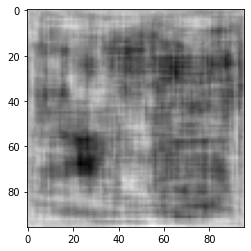

In [72]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap="gray")
plt.show()

### Detemining if the generated image is real or fake using the discriminator model before training

In [73]:
generated_image.shape

TensorShape([1, 96, 96, 3])

In [74]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
discriminator = build_discriminator(image_shape)
discriminator(generated_image)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5004422]], dtype=float32)>

### Loss Functions.

Loss functions must be developed that allow the generator and discriminator to be trained in an adversarial way. Because these two neural networks are being trained independently they must be trained in two separate passes. This requires two separate loss functions and also two separate updates to the gradients. When the discriminator's gradients are applied to decrease the discriminator's loss it is important that only the discriminator's weights are update. It is not fair, nor will it produce good results, to adversarially damage the weights of the generator to help the discriminator. A simple backpropagation would do this. It would simultaneously affect the weights of both generator and discriminator to lower whatever loss it was assigned to lower.

In [76]:

cross_entropy = keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  return real_loss + fake_loss

def generator_loss(fake_output):
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
  return fake_loss

### Optimizers.
Both the generator and the discriminator will have the same optimizer.

In [57]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

### Train step function.

In [77]:
@tf.function
def train_step(images):
  seed = tf.random.normal((BATCH_SIZE, SEED_SIZE))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)
    
    real_output = disciminator(images, training=True)
    fake_output = disciminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, disciminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, disciminator.trainable_variables
    ))
      
  return gen_loss, disc_loss

### Function that saves images

In [78]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  generated_images = generator.predict(noise)
  generated_images = 0.5 * generated_images + 0.5
  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

### The Train function
In this function we are going to use a fixed_seed to get reliable results.

In [83]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (
      PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE
  ))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []
    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      gen_loss_list.append(gen_loss)
      disc_loss_list.append(disc_loss)

    g_loss = sum(gen_loss_list)/len(gen_loss_list)
    d_loss = sum(disc_loss_list)/len(disc_loss_list)

    epoch_elapsed = time.time() - epoch_start
    print (f'Epoch {epoch+1}, gen loss:{g_loss}, disc loss:{d_loss}, time: {hms_string(epoch_elapsed)}')
    save_images(epoch, fixed_seed)
    
  elapsed = time.time() - start
  print (f'Training time: {hms_string(elapsed)}')

### Training the model.

In [84]:
train(train_ds, EPOCHS)

Epoch 1, gen loss:3.101010322570801, disc loss:0.5049039125442505, time: 0:00:31.74
Epoch 2, gen loss:3.0564281940460205, disc loss:0.5001291036605835, time: 0:00:31.05
Epoch 3, gen loss:3.1405413150787354, disc loss:0.48067930340766907, time: 0:00:30.66
Epoch 4, gen loss:3.1764109134674072, disc loss:0.4602716565132141, time: 0:00:30.76
Epoch 5, gen loss:3.1076247692108154, disc loss:0.4829595685005188, time: 0:00:30.87
Epoch 6, gen loss:3.3016257286071777, disc loss:0.404596209526062, time: 0:00:30.75
Epoch 7, gen loss:3.3638546466827393, disc loss:0.3831261992454529, time: 0:00:30.76
Epoch 8, gen loss:3.6864962577819824, disc loss:0.3142451047897339, time: 0:00:30.81
Epoch 9, gen loss:3.8036553859710693, disc loss:0.31985872983932495, time: 0:00:30.85
Epoch 10, gen loss:3.870201826095581, disc loss:0.288115531206131, time: 0:00:30.83
Epoch 11, gen loss:4.048121929168701, disc loss:0.2600848972797394, time: 0:00:30.81
Epoch 12, gen loss:4.188435077667236, disc loss:0.2357971966266632

### Generating some faces

In [87]:
seeds = tf.random.normal([32, SEED_SIZE])
generated_image = generator(seeds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

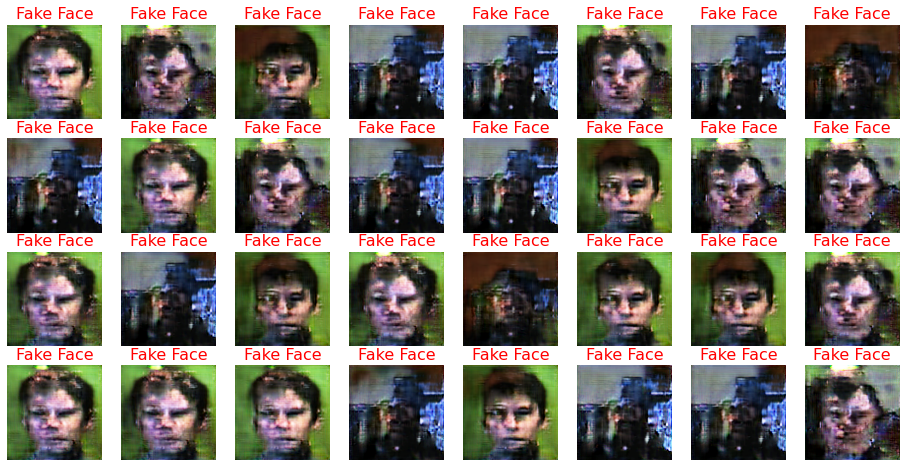

In [96]:
def plot_images(images_and_classes, cols=5):
    rows = 4
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image) in enumerate(images_and_classes):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(np.array(image.numpy() * 255,np.int32) , cmap="gray")
        plt.title("Fake Face", color ='r', fontsize=16 )

plot_images(generated_image[:], cols=8)

#### Credits

* [jeffheaton](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb)